# Imports

In [193]:
# link to all dfs: https://nijianmo.github.io/amazon/index.html
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import twokenize # from homework 2b
from porter_stemmer import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
import tensorflow_hub as hub
import re
from tensorflow.keras import layers
import torch 
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from tqdm.notebook import tqdm
import random
import warnings
warnings.filterwarnings("ignore")

# Download and Read Data

In [59]:
# Download dataframes (warning: large!)
fnames = ["Video_Games_5.json", 
          "Software_5.json", 
          "Prime_Pantry_5.json", 
          "Office_Products_5.json", 
          "Cell_Phones_and_Accessories_5.json",
          "Grocery_and_Gourmet_Food_5.json",
          "Health_and_Personal_Care_5.json",
          "Musical_Instruments_5.json"
        ]
choice = input("Are you sure you want to download all of the datasets? [y/n]:")
![[ -d "data" ]] || mkdir data
if choice.lower() in ['y', 'yes']:
    for fname in fnames:
        url = "https://jmcauley.ucsd.edu/data/amazon_v2/categoryFilesSmall/" + fname + ".gz"
        out = "data/" + fname + ".gz" 
        !curl -k {url} -o {out}
        !gunzip {out} # decompress gz

Are you sure you want to download all of the datasets? [y/n]:y
gzip: data/Software_5.json.gz: No such file or directory


In [33]:
def read_df(filename, chunksize = 1000):
    reader = pd.read_json(filename, lines = True, chunksize = chunksize)
    for chunk in reader:
        df = chunk
        break
    df["reviewTime"] = pd.to_datetime(df["reviewTime"])
    df = df.drop_duplicates(subset = ["reviewTime", "reviewerID", "asin"])
    for column in ["verified", "reviewTime", "reviewerID", "asin", "reviewerName", "unixReviewTime", "vote", "style", "image"]:
        if column in df.columns:
            df = df.drop(columns = [column])
    df = df.dropna(subset = ['reviewText'])
    df = df.reset_index(drop = True)
    return df

In [52]:
# https://jmcauley.ucsd.edu/data/amazon_v2/categoryFilesSmall/Video_Games_5.json.gz
df_videogames = read_df("data/Video_Games_5.json", chunksize = 25000)

# never used, just saved in case something happens to df_videogames
df1 = df_videogames.copy(deep = True)

df = df_videogames.iloc[:21000]

In [196]:
software_df = read_df("data/Software_5.json", chunksize = 1000)
primepantry_df = read_df("data/Prime_Pantry_5.json", chunksize = 1000)
officeproducts_df = read_df("data/Office_Products_5.json", chunksize = 1000)
cellphones_df = read_df("data/Cell_Phones_and_Accessories_5.json", chunksize = 1000)
grocery_df = read_df("data/Grocery_and_Gourmet_Food_5.json", chunksize = 1000)
personalcare_df = read_df("data/Health_and_Personal_Care_5.json", chunksize = 1000)
music_df = read_df("data/Musical_Instruments_5.json", chunksize = 1000)

OOS_dfs = dict()
OOS_dfs["Software"] = software_df
OOS_dfs["Prime Pantry"] = primepantry_df
OOS_dfs["Office Products"] = officeproducts_df
OOS_dfs["Cell Phones"] = cellphones_df
OOS_dfs["Grocery"] = grocery_df
OOS_dfs["Personal Care"] = personalcare_df
OOS_dfs["Musical Instruments"] = music_df

['Software',
 'Prime Pantry',
 'Office Products',
 'Cell Phones',
 'Grocery',
 'Personal Care',
 'Musical Instruments']

# Visualize Distribution of Data

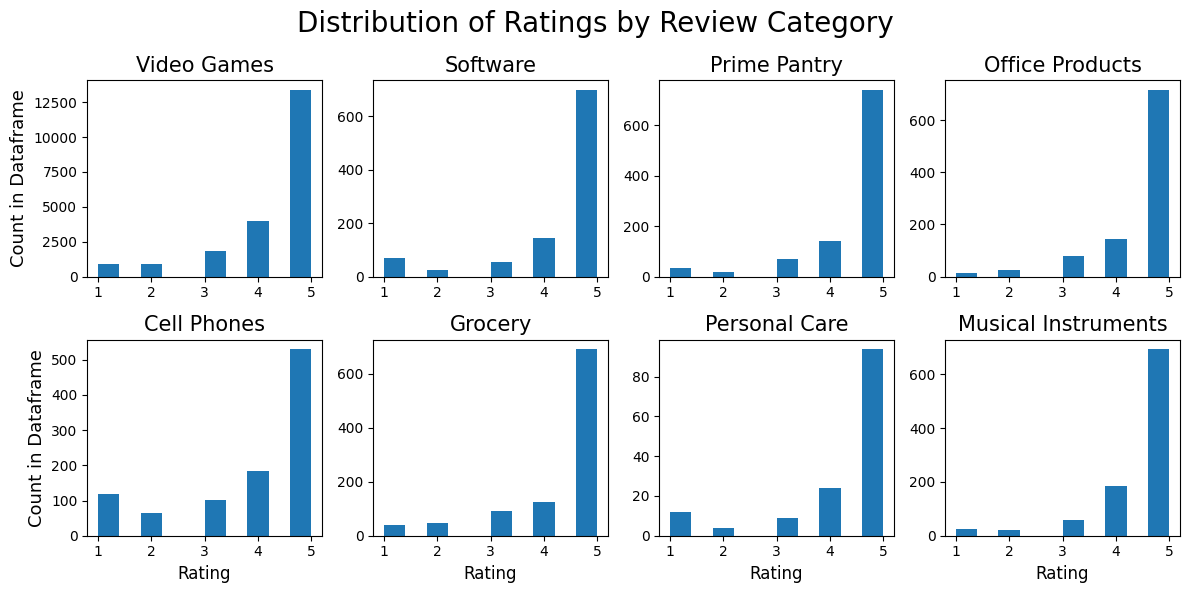

In [230]:
df_list = [df, software_df, primepantry_df, officeproducts_df, cellphones_df, grocery_df, personalcare_df, music_df]
df_categories = ['Video Games'] + list(OOS_dfs.keys())
nrows = 2; ncols = 4
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*3, nrows*3))
for i in range(nrows):
    for j in range(ncols):
        idx = i*ncols + j
        axs[i,j].hist(df_list[idx]['overall'])
        axs[i,j].set_xticks([1,2,3,4,5])
        axs[i,j].set_title(df_categories[idx], fontsize=15)
        if i == nrows-1:
            axs[i,j].set_xlabel("Rating", fontsize=12)
        if j == 0:
            axs[i,j].set_ylabel("Count in Dataframe", fontsize=13)
        
fig.suptitle('Distribution of Ratings by Review Category', fontsize=20)
fig.tight_layout()

# Prepare Features

In [61]:
# code taken from homework 2b student_code.py
neg_words =  set([x.strip() for x in open("res/negative-words.txt", encoding="ISO-8859-1").readlines() if not(x.startswith(";"))])
neg_words.remove("")

pos_words =  set([x.strip() for x in open("res/positive-words.txt", encoding="ISO-8859-1").readlines() if not(x.startswith(";"))])
pos_words.remove("")

features = {
    'contains_!' : lambda x: int("!" in x),
    'num_positive' : lambda x: sum([word.lower() in pos_words for word in twokenize.tokenize(x)]),
    'num_negative' : lambda x: sum([word.lower() in neg_words for word in twokenize.tokenize(x)]),
    'length' : len
}

In [62]:
def create_variables(df_):

    X = pd.DataFrame()

    # build up the features data-matrix X by applying all of the features
    review_strings = df_['reviewText'].astype(str)
    for feature, f in features.items():
        X[feature] = review_strings.apply(f)

    y = np.where(df_["overall"] <= 3, 0, 1)
    
    return X, y

In [63]:
def create_ts_variables(df_):
    
    df_ts = df_.copy(deep = True)
    df_ts = df_ts.drop(columns = ["reviewText"])
    df_ts["summary"] = df_ts["summary"].astype(str).apply(lambda x: re.sub("[0-9]", "", x))

    X = df_ts["summary"]
    y = np.where(df_ts["overall"] <= 3, 0, 1)
    
    return X, y

In [74]:
TEST_DF = df.iloc[-1000:]
X_TEST, Y_TEST = create_variables(TEST_DF)
X_TEST_TS, Y_TEST_TS = create_ts_variables(TEST_DF)

TRAIN_DF = df.iloc[:-1000]
X_TRAIN, Y_TRAIN = create_variables(TRAIN_DF)
X_TRAIN_TS, Y_TRAIN_TS = create_ts_variables(TRAIN_DF)

seed = 1001
train_sizes = list(np.logspace(-3, -0.1, 10))
train_sizes_XY = []
for train_size in train_sizes:
    X, _, y, _ = train_test_split(X_TRAIN, Y_TRAIN, train_size = train_size, random_state = seed)
    X_ts, _, y_ts, _ = train_test_split(X_TRAIN_TS, Y_TRAIN_TS, train_size = train_size, random_state = seed)
    train_sizes_XY.append(((X, y), (X_ts, y_ts)))

In [64]:
OOS_XY = dict()
for name in OOS_dfs.keys():
    OOS_df = OOS_dfs[name]
    X, y = create_variables(OOS_df)
    X_ts, y_ts = create_ts_variables(OOS_df)
    OOS_XY[name] = [(X, y), (X_ts, y_ts)]

In [65]:
OOS_XY["Software"][0][0]

,contains_!,num_positive,num_negative,length
0,0,9,1,1237
1,0,13,7,2439
2,0,28,11,8410
3,0,15,3,2475
4,1,8,3,1188
...,...,...,...,...
988,0,16,8,2376
989,0,10,4,1368
990,1,24,15,3642
991,0,2,1,216


# Helper Functions

In [66]:
def metrics(y_hat, y, threshold = 0.5, target = "positive"):
    
    if isinstance(y_hat, np.ndarray):
        y_hat = y_hat.flatten()
    
    predicted = (pd.Series(y_hat) > threshold).astype(int).reset_index(drop = True)
    actual = pd.Series(y).astype(int).reset_index(drop = True)
            
    TP = (actual * predicted).astype(bool).sum()
    TN = ((actual-1) * (predicted-1)).astype(bool).sum()
    FP = ((actual-1) * predicted).astype(bool).sum()
    FN = (actual * (predicted-1)).astype(bool).sum()
            
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    
    if target == "positive":
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        
    if target == "negative":
        precision = TN / (TN + FN)
        recall = TN / (TN + FP)
        
    f = 2 / (1/precision + 1/recall)
    
    return accuracy, precision, recall, f

def roc(y, y_hat, target = "positive"):
    if target == "positive":
        FP, TP, _ = roc_curve(y, y_hat)
        plt.plot(FP, TP, label = "positive")
    if target == "negative":
        y = -1 * y + 1
        y_hat = -1 * y_hat + 1
        FP, TP, _ = roc_curve(y, y_hat)
        plt.plot(FP, TP, label = "negative")

# 1) Feature-Based Models

# Logistic Regression

In [67]:
def LR(X_train, X_test, y_train, y_test):
    
    model = LogisticRegression(class_weight = "balanced").fit(X_train, y_train)
    y_hat = model.predict(X_test)
    
    return model, y_hat

# Naive Bayes

In [68]:
def NB(X_train, X_test, y_train, y_test):
    
    model = ComplementNB().fit(X_train, y_train)
    y_hat = model.predict(X_test)
    
    return model, y_hat

# Feedforward Neural Network

In [69]:
def NN(X_train, X_test, y_train, y_test):

    model = tf.keras.Sequential()
    model.add(layers.Dense(4, activation = "tanh"))
    model.add(layers.Dense(1, activation = "sigmoid"))

    w0 = len(y_train) / (2 * sum(y_train == 0))
    w1 = len(y_train) / (2 * sum(y_train == 1))

    _, X_val, _, y_val = train_test_split(X_test, y_test, test_size = 0.1)
    model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])
    history = model.fit(X_train, y_train, epochs = 1000, batch_size = len(y_train), class_weight = {0: w0, 1: w1},
                        validation_data = (X_val, y_val), verbose = 0)

    y_hat = model.predict(X_test, verbose = 0)
    
    return model, y_hat

# 2) Time Series Models

# Recurrent Neural Network

In [70]:
def RNN(X_train, X_test, y_train, y_test):

    model = tf.keras.models.Sequential()
    model.add(layers.Input(shape = (1,), dtype = tf.string))

    vectorize_layer = layers.TextVectorization(max_tokens = 1000, output_mode = "int", output_sequence_length = 15)
    text = tf.convert_to_tensor(X_train.astype(str))
    vectorize_layer.adapt(text)
    model.add(vectorize_layer)

    w0 = len(y_train) / (2 * sum(y_train == 0))
    w1 = len(y_train) / (2 * sum(y_train == 1))

    model.add(layers.Embedding(1000, 32))
    model.add(layers.Bidirectional(layers.SimpleRNN(8)))
    model.add(layers.Dense(1, activation = "sigmoid"))
    
    _, X_val, _, y_val = train_test_split(X_test, y_test, test_size = 0.1)
    model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])
    history = model.fit(X_train, y_train, epochs = 50, class_weight = {0: w0, 1: w1}, 
                        validation_data = (X_val, y_val), verbose = 0)
    
    y_hat = model.predict(X_test, verbose = 0)
    
    return model, y_hat

In [127]:
model1 = tf.keras.models.Sequential()
model1.add(layers.Input(shape = (1,), dtype = tf.string))

vectorize_layer = layers.TextVectorization(max_tokens = 1000, output_mode = "int", output_sequence_length = 15)
model1.add(vectorize_layer)


model1.add(layers.Embedding(1000, 32))
model1.add(layers.Bidirectional(layers.SimpleRNN(8)))
model1.add(layers.Dense(1, activation = "sigmoid"))
model1.summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_23 (Text  (None, 15)               0         
 Vectorization)                                                  
                                                                 
 embedding_23 (Embedding)    (None, 15, 32)            32000     
                                                                 
 bidirectional_23 (Bidirecti  (None, 16)               656       
 onal)                                                           
                                                                 
 dense_45 (Dense)            (None, 1)                 17        
                                                                 
Total params: 32,673
Trainable params: 32,673
Non-trainable params: 0
_________________________________________________________________


# Gated Recurrent Network

In [71]:
def GRU(X_train, X_test, y_train, y_test, vocab_analysis = False):
    
    model = tf.keras.models.Sequential()
    model.add(layers.Input(shape = (1,), dtype = tf.string))

    vectorize_layer = layers.TextVectorization(max_tokens = 1000, output_mode = "int", output_sequence_length = 15)
    text = tf.convert_to_tensor(X_train.astype(str))
    vectorize_layer.adapt(text)
    model.add(vectorize_layer)

    w0 = len(y_train) / (2 * sum(y_train == 0))
    w1 = len(y_train) / (2 * sum(y_train == 1))

    model.add(layers.Embedding(1000, 32))
    model.add(layers.Bidirectional(layers.GRU(8)))
    model.add(layers.Dense(1, activation = "sigmoid"))
    
    _, X_val, _, y_val = train_test_split(X_test, y_test, test_size = 0.1)
    model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])
    history = model.fit(X_train, y_train, epochs = 50, class_weight = {0: w0, 1: w1}, 
                        validation_data = (X_val, y_val), verbose = 0)

    y_hat = model.predict(X_test, verbose = 0)
    
    ###################################################################################
    if vocab_analysis == True:
        vocab = vectorize_layer.get_vocabulary()

        vocab = pd.Series(vocab).to_frame()
        vocab.columns = ["Word"]
        vocab["Sentiment"] = model.predict(vocab).flatten()
        vocab = vocab.sort_values(by = "Sentiment").reset_index(drop = True)

        positive = list(vocab["Word"].iloc[-10:])
        negative = list(vocab["Word"].iloc[:10])

        print()
        print(f"Ten Most Positive Words:\n{positive}")
        print()
        print(f"Ten Most Negative Words:\n{negative}")
        return
    
    return model, y_hat

# Transformer

In [72]:
def BERT(X_train, X_test, y_train, y_test):

    checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
    tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path = checkpoint)
    model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
    raw_inputs = list(X_test.astype(str))
    y_hat = np.empty(len(raw_inputsuts))
    for i in tqdm(range(0, len(raw_inputs), 100)):
        j = min(i + 100, len(raw_inputs))
        inputs = tokenizer(raw_inputs[i:j], padding = True, truncation = True, return_tensors = "pt")
        outputs = model(**inputs)
        outputs = torch.nn.functional.softmax(outputs.logits, dim = -1)
        y_hat[i:j] = outputs[:,1].detach().numpy()
        
    return model, y_hat

# Final Results

In [75]:
num_train_list = [round(train_size * len(X_TRAIN)) for train_size in train_sizes]
index = pd.MultiIndex.from_product([["LR", "NB", "NN", "RNN", "GRU"], num_train_list], names = ["Model", "Size"])
results = pd.DataFrame(index = index, columns = ["Accuracy", "(+) F", "(-) F"])

for i in tqdm(range(len(train_sizes))):
        
    num_train = round(train_sizes[i] * len(X_TRAIN))
    ((X, y), (X_ts, y_ts)) = train_sizes_XY[i]
        
    _, y_hat = LR(X, X_TEST, y, Y_TEST)
    accuracy, _, _, positive_f = metrics(y_hat, Y_TEST, target = "positive")
    _, _, _, negative_f = metrics(y_hat, Y_TEST, target = "negative")
    results.loc["LR", num_train, :] = (accuracy, positive_f, negative_f)
    
    _, y_hat = NB(X, X_TEST, y, Y_TEST)
    accuracy, _, _, positive_f = metrics(y_hat, Y_TEST, target = "positive")
    _, _, _, negative_f = metrics(y_hat, Y_TEST, target = "negative")
    results.loc["NB", num_train, :] = (accuracy, positive_f, negative_f)
    
    _, y_hat = NN(X, X_TEST, y, Y_TEST)
    accuracy, _, _, positive_f = metrics(y_hat, Y_TEST, target = "positive")
    _, _, _, negative_f = metrics(y_hat, Y_TEST, target = "negative")
    results.loc["NN", num_train, :] = (accuracy, positive_f, negative_f)

    _, y_hat = RNN(X_ts, X_TEST_TS, y_ts, Y_TEST_TS)
    accuracy, _, _, positive_f = metrics(y_hat, Y_TEST_TS, target = "positive")
    _, _, _, negative_f = metrics(y_hat, Y_TEST_TS, target = "negative")
    results.loc["RNN", num_train, :] = (accuracy, positive_f, negative_f)

    _, y_hat = GRU(X_ts, X_TEST_TS, y_ts, Y_TEST_TS)
    accuracy, _, _, positive_f = metrics(y_hat, Y_TEST_TS, target = "positive")
    _, _, _, negative_f = metrics(y_hat, Y_TEST_TS, target = "negative")
    results.loc["GRU", num_train, :] = (accuracy, positive_f, negative_f)

  0%|          | 0/10 [00:00<?, ?it/s]

2023-05-06 21:20:57.835346: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-05-06 21:20:57.835407: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-06 21:20:57.835436: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (T480sArch): /proc/driver/nvidia/version does not exist
2023-05-06 21:20:57.838223: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


NameError: name 'Transformer' is not defined

In [79]:
_, y_hat = BERT(None, X_TEST_TS, None, Y_TEST_TS)
accuracy, _, _, positive_f = metrics(y_hat, Y_TEST_TS, target = "positive")
_, _, _, negative_f = metrics(y_hat, Y_TEST_TS, target = "negative")
for num_train in num_train_list:
    results.loc[("BERT", num_train), :] = (accuracy, positive_f, negative_f)
    
results_with_BERT = results.copy(deep = True)
results = results_with_BERT.loc[["LR", "NB", "NN", "RNN", "GRU"], :, :]

  0%|          | 0/10 [00:00<?, ?it/s]

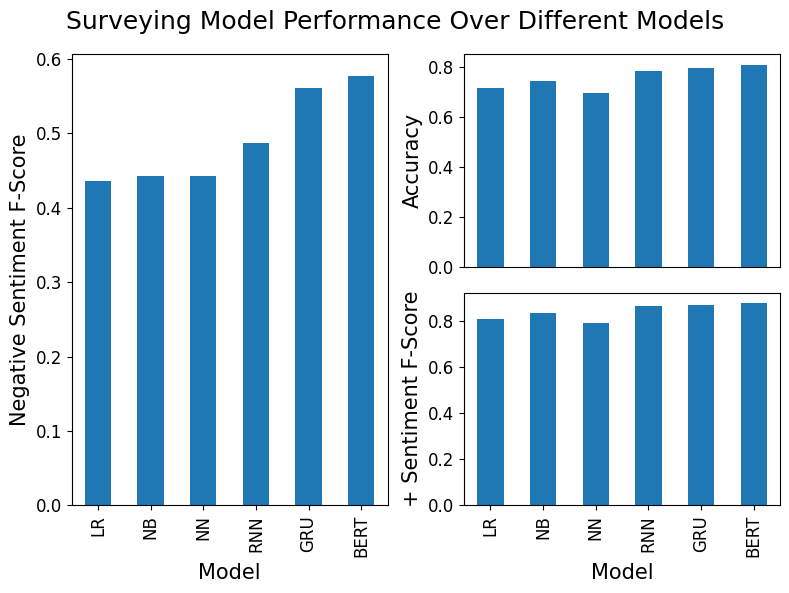

In [80]:
plt.figure(figsize = (8,6))

temp = results_with_BERT.groupby("Model").last().reindex(["LR", "NB", "NN", "RNN", "GRU", "BERT"])

ax1 = plt.subplot(1,2,1)
temp["(-) F"].plot(kind = "bar", ax = ax1)
ax1.set_xlabel("Model", fontsize = 15)
ax1.set_ylabel("Negative Sentiment F-Score", fontsize = 15)
ax1.tick_params(labelsize = 12)

ax2 = plt.subplot(2,2,2)
temp["Accuracy"].plot(kind = "bar", ax = ax2)
ax2.tick_params(labelsize = 12)
ax2.set_xticks([])
ax2.set_xlabel("")
ax2.set_ylabel("Accuracy", fontsize = 15)

ax3 = plt.subplot(2,2,4)
temp["(+) F"].plot(kind = "bar", ax = ax3)
ax3.set_xlabel("Model", fontsize = 15)
ax3.tick_params(axis = "both", labelsize = 12)
ax3.set_ylabel("+ Sentiment F-Score", fontsize = 15)

plt.suptitle("Surveying Model Performance Over Different Models", fontsize = 18)
plt.tight_layout()

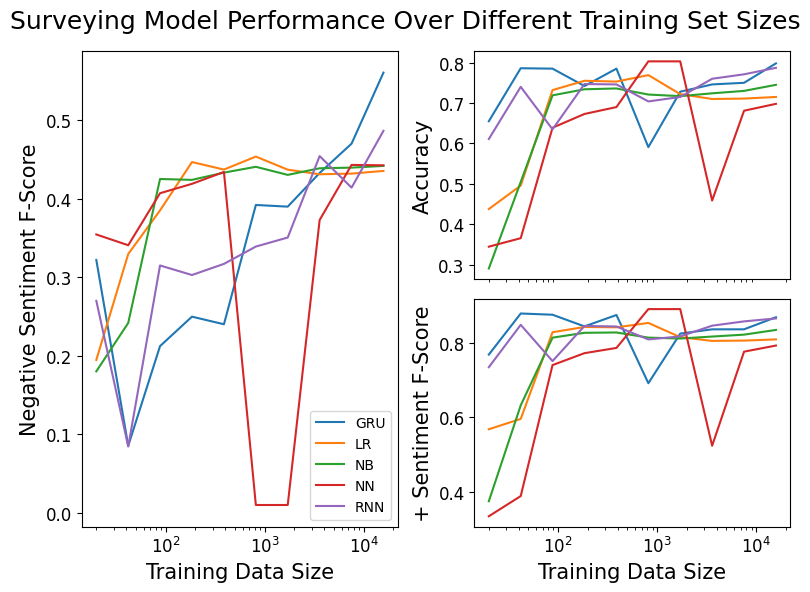

In [84]:
plt.figure(figsize = (8,6))

ax1 = plt.subplot(1,2,1)
for model, _ in results.groupby(level = 0):
    results.loc[model]["(-) F"].plot(label = model, ax = ax1)
ax1.set_xscale("log")
ax1.set_xlabel("Training Data Size", fontsize = 15)
ax1.set_ylabel("Negative Sentiment F-Score", fontsize = 15)
ax1.tick_params(labelsize = 12)
ax1.legend(loc = "lower right")

ax2 = plt.subplot(2,2,2)
for model, _ in results.groupby(level = 0):
    results.loc[model]["Accuracy"].plot(label = model, ax = ax2)
ax2.set_xscale("log")
ax2.tick_params(labelsize = 12)
ax2.set_xticks([])
ax2.set_xlabel("")
ax2.set_ylabel("Accuracy", fontsize = 15)

ax3 = plt.subplot(2,2,4)
for model, _ in results.groupby(level = 0):
    results.loc[model]["(+) F"].plot(label = model, ax = ax3)
ax3.set_xlabel("Training Data Size", fontsize = 15)
ax3.set_xscale("log")
ax3.tick_params(labelsize = 12)
ax3.set_ylabel("+ Sentiment F-Score", fontsize = 15)

plt.suptitle("Surveying Model Performance Over Different Training Set Sizes", fontsize = 18)
plt.tight_layout()

In [87]:
num_train = round(train_sizes[-1] * len(X_TRAIN))
((X, y), (X_ts, y_ts)) = train_sizes_XY[-1]

index = pd.MultiIndex.from_product([["LR", "NB", "NN", "RNN", "GRU"], list(OOS_XY.keys()) + ["Video Games"]], 
                                   names = ["Model", "OOS DF"])
OOS_results = pd.DataFrame(index = index, columns = ["Accuracy", "(+) F", "(-) F"])

lr_model, y_hat = LR(X, X_TEST, y, Y_TEST)
accuracy, _, _, positive_f = metrics(y_hat, Y_TEST, target = "positive")
_, _, _, negative_f = metrics(y_hat, Y_TEST, target = "negative")
OOS_results.loc["LR", "Video Games", :] = (accuracy, positive_f, negative_f)
for name in OOS_XY.keys():
    [(X_temp, y_temp), (_, _)] = OOS_XY[name]
    y_hat = lr_model.predict(X_temp)
    accuracy, _, _, positive_f = metrics(y_hat, y_temp, target = "positive")
    _, _, _, negative_f = metrics(y_hat, y_temp, target = "negative")
    OOS_results.loc["LR", name, :] = (accuracy, positive_f, negative_f)

nb_model, y_hat = NB(X, X_TEST, y, Y_TEST)
accuracy, _, _, positive_f = metrics(y_hat, Y_TEST, target = "positive")
_, _, _, negative_f = metrics(y_hat, Y_TEST, target = "negative")
OOS_results.loc["NB", "Video Games", :] = (accuracy, positive_f, negative_f)
for name in OOS_XY.keys():
    [(X_temp, y_temp), (_, _)] = OOS_XY[name]
    y_hat = nb_model.predict(X_temp)
    accuracy, _, _, positive_f = metrics(y_hat, y_temp, target = "positive")
    _, _, _, negative_f = metrics(y_hat, y_temp, target = "negative")
    OOS_results.loc["NB", name, :] = (accuracy, positive_f, negative_f)

nn_model, y_hat = NN(X, X_TEST, y, Y_TEST)
accuracy, _, _, positive_f = metrics(y_hat, Y_TEST, target = "positive")
_, _, _, negative_f = metrics(y_hat, Y_TEST, target = "negative")
OOS_results.loc["NN", "Video Games", :] = (accuracy, positive_f, negative_f)
for name in OOS_XY.keys():
    [(X_temp, y_temp), (_, _)] = OOS_XY[name]
    y_hat = nn_model.predict(X_temp, verbose = 0)
    accuracy, _, _, positive_f = metrics(y_hat, y_temp, target = "positive")
    _, _, _, negative_f = metrics(y_hat, y_temp, target = "negative")
    OOS_results.loc["NN", name, :] = (accuracy, positive_f, negative_f)
    
rnn_model, y_hat = RNN(X_ts, X_TEST_TS, y_ts, Y_TEST_TS)
accuracy, _, _, positive_f = metrics(y_hat, Y_TEST_TS, target = "positive")
_, _, _, negative_f = metrics(y_hat, Y_TEST_TS, target = "negative")
OOS_results.loc["RNN", "Video Games", :] = (accuracy, positive_f, negative_f)
for name in OOS_XY.keys():
    [(_, _), (X_temp, y_temp)] = OOS_XY[name]
    y_hat = rnn_model.predict(X_temp, verbose = 0)
    accuracy, _, _, positive_f = metrics(y_hat, y_temp, target = "positive")
    _, _, _, negative_f = metrics(y_hat, y_temp, target = "negative")
    OOS_results.loc["RNN", name, :] = (accuracy, positive_f, negative_f)
    
gru_model, y_hat = GRU(X_ts, X_TEST_TS, y_ts, Y_TEST_TS)
accuracy, _, _, positive_f = metrics(y_hat, Y_TEST_TS, target = "positive")
_, _, _, negative_f = metrics(y_hat, Y_TEST_TS, target = "negative")
OOS_results.loc["GRU", "Video Games", :] = (accuracy, positive_f, negative_f)
for name in OOS_XY.keys():
    [(_, _), (X_temp, y_temp)] = OOS_XY[name]
    y_hat = gru_model.predict(X_temp, verbose = 0)
    accuracy, _, _, positive_f = metrics(y_hat, y_temp, target = "positive")
    _, _, _, negative_f = metrics(y_hat, y_temp, target = "negative")
    OOS_results.loc["GRU", name, :] = (accuracy, positive_f, negative_f)

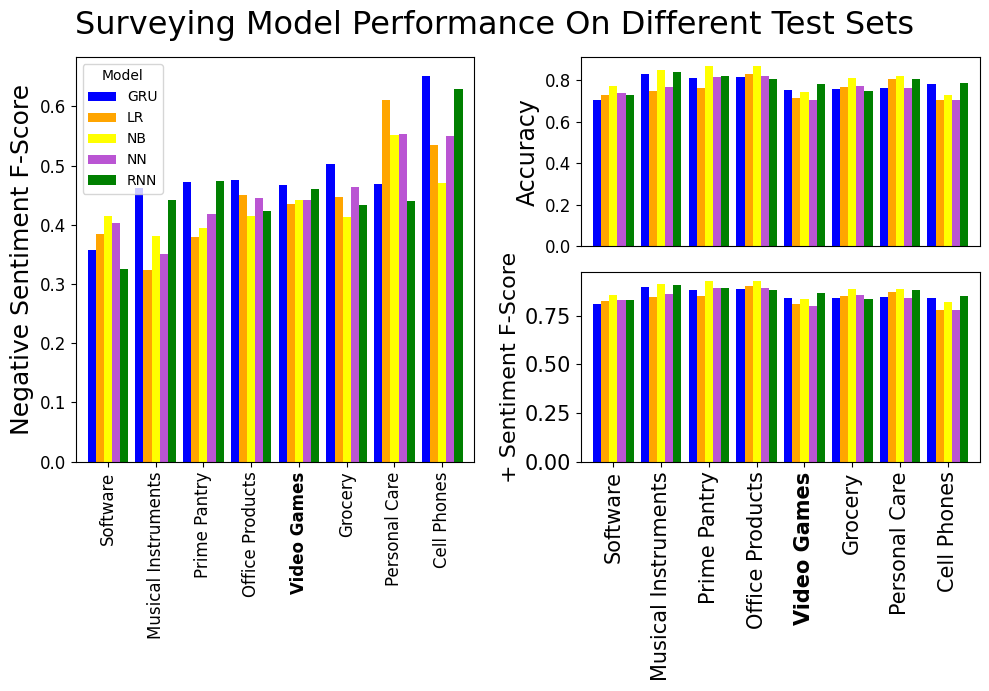

In [192]:
plt.figure(figsize = (10,7))

temp = OOS_results.copy(deep = True)
temp.index = temp.index.swaplevel()
ordering = temp["(-) F"].groupby("OOS DF").mean().sort_values(ascending = True).index
temp = temp.unstack().reindex(index = ordering)

ax1 = plt.subplot(1,2,1)                               
temp["(-) F"].plot(kind = "bar", ax = ax1, width=0.85, 
                   # increase contrast for improved visibility
                   color=['blue', 'orange', 'yellow', 'mediumorchid', 'green'])
ax1.set_xlabel("")
ax1.set_ylabel("Negative Sentiment F-Score", fontsize = 18)
ax1.tick_params(labelsize = 12)
for label in ax1.get_xticklabels():
    if label.get_text() == "Video Games":
        label.set_fontweight('bold')

ax2 = plt.subplot(2,2,2)
temp["Accuracy"].plot(kind = "bar", ax = ax2, width=0.85, color=['blue', 'orange', 'yellow', 'mediumorchid', 'green'])
ax2.get_legend().remove()
ax2.set_xticks([])
ax2.set_xlabel("")
ax2.tick_params(labelsize = 12)
ax2.set_ylabel("Accuracy", fontsize = 17)

ax3 = plt.subplot(2,2,4)
temp["(+) F"].plot(kind = "bar", ax = ax3, width=0.85, color=['blue', 'orange', 'yellow', 'mediumorchid', 'green'])
ax3.get_legend().remove()
ax3.set_xlabel("")
ax3.tick_params(labelsize = 15)
ax3.set_ylabel("\n+ Sentiment F-Score", fontsize = 16)
for label in ax3.get_xticklabels():
    if label.get_text() == "Video Games":
        label.set_fontweight('bold')

plt.suptitle("Surveying Model Performance On Different Test Sets",
            fontsize = 23)
plt.tight_layout()

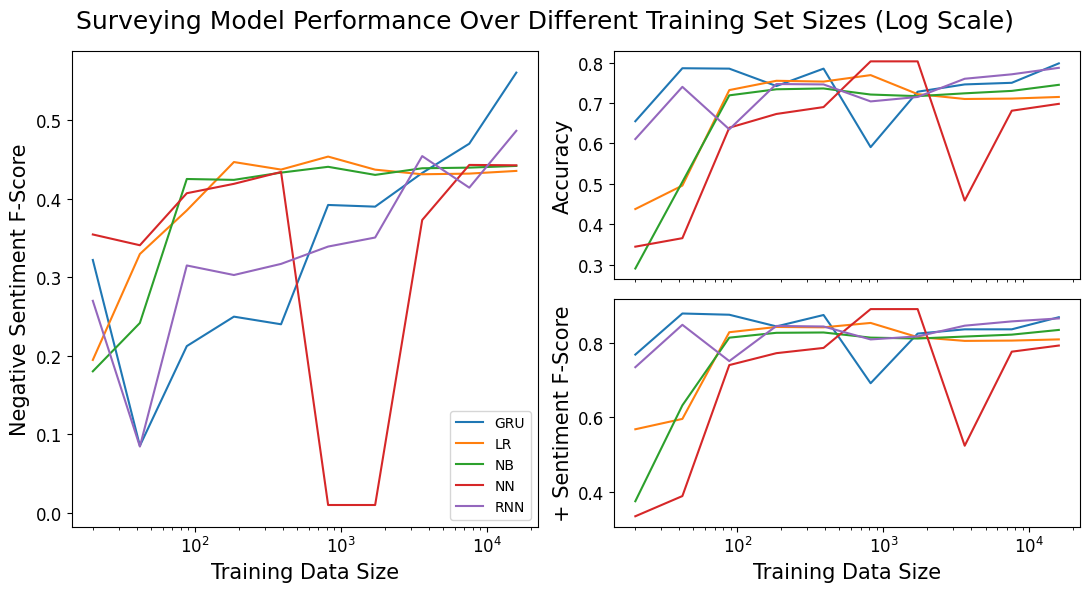

In [89]:
plt.figure(figsize = (11,6))

ax1 = plt.subplot(1,2,1)
for model, _ in results.groupby(level = 0):
    results.loc[model]["(-) F"].plot(label = model, ax = ax1)
ax1.set_xscale("log")
ax1.set_xlabel("Training Data Size", fontsize = 15)
ax1.set_ylabel("Negative Sentiment F-Score", fontsize = 15)
ax1.tick_params(labelsize = 12)
ax1.legend(loc = "lower right")

ax2 = plt.subplot(2,2,2)
for model, _ in results.groupby(level = 0):
    results.loc[model]["Accuracy"].plot(label = model, ax = ax2)
ax2.set_xscale("log")
ax2.tick_params(labelsize = 12)
ax2.set_xticks([])
ax2.set_xlabel("")
ax2.set_ylabel("Accuracy", fontsize = 15)

ax3 = plt.subplot(2,2,4)
for model, _ in results.groupby(level = 0):
    results.loc[model]["(+) F"].plot(label = model, ax = ax3)
ax3.set_xlabel("Training Data Size", fontsize = 15)
ax3.set_xscale("log")
ax3.tick_params(labelsize = 12)
ax3.set_ylabel("+ Sentiment F-Score", fontsize = 15)

plt.suptitle("Surveying Model Performance Over Different Training Set Sizes (Log Scale)", fontsize = 18)
plt.tight_layout()

In [125]:
results.loc["GRU"]["Accuracy"].axes
results.loc["GRU"]["Accuracy"].values

array([0.655, 0.786, 0.785, 0.742, 0.785, 0.591, 0.728, 0.746, 0.75,
       0.798], dtype=object)

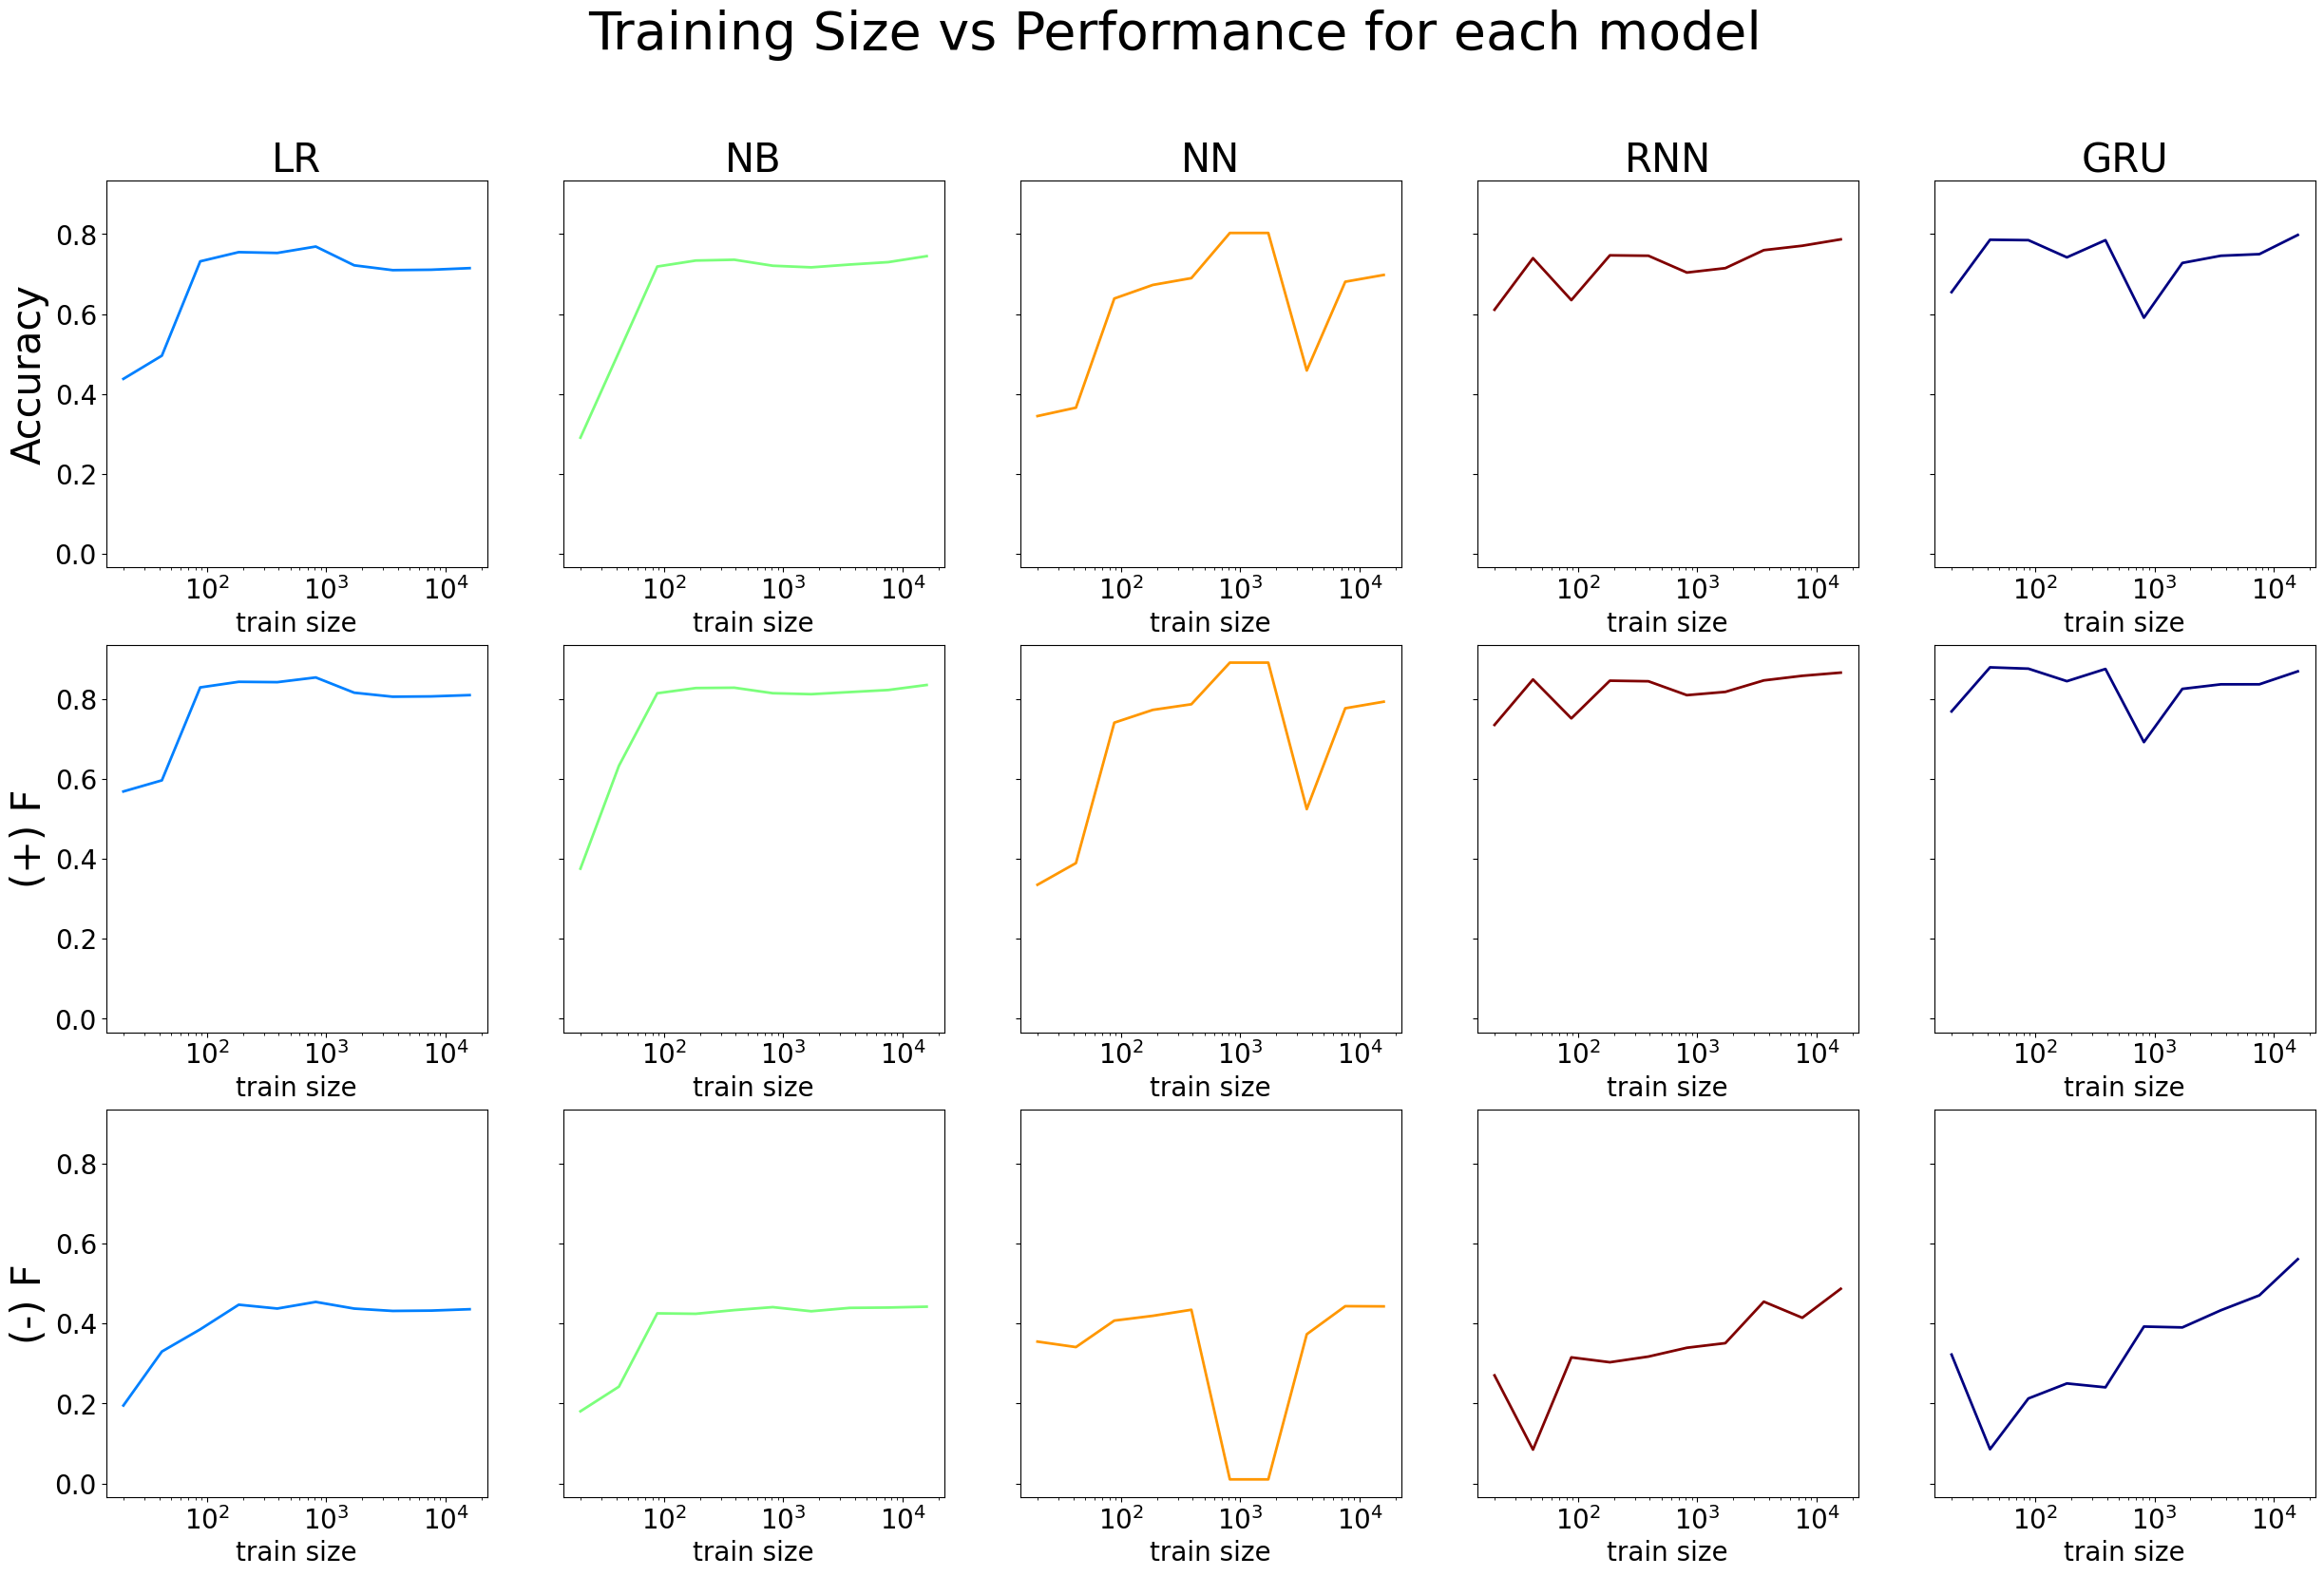

In [161]:
num_models = 5
cmap = plt.cm.get_cmap("jet", num_models)
nrows = 3
ncols = num_models
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*6, nrows*6), sharey=True)
fig.suptitle("Training Size vs Performance for each model", fontsize=40)
for i,metric in enumerate(("Accuracy", "(+) F", "(-) F")):
    for j, (model, _) in enumerate(results.groupby(level=0)):
        col_ind = j-1 if model != "GRU" else num_models-1
        ax = axs[i,col_ind]
        results.loc[model][metric].plot(label = model, ax = ax, c=cmap(j), linewidth=2)
        ax.set_xscale("log")
        ax.set_xlabel("train size", fontsize = 20)
        ax.tick_params(labelsize = 20)
        if i == 0:
            ax.set_title(model, fontsize=30)
        if col_ind == 0:
            full_name = {"Accuracy":"Accuracy", "(+) F":"Positive Sentiment F-Score", "(-) F":"Negative Sentiment F-Score"}
            ax.set_ylabel(metric, fontsize = 30)

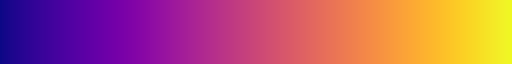

In [149]:
plt.cm.get_cmap("mag")

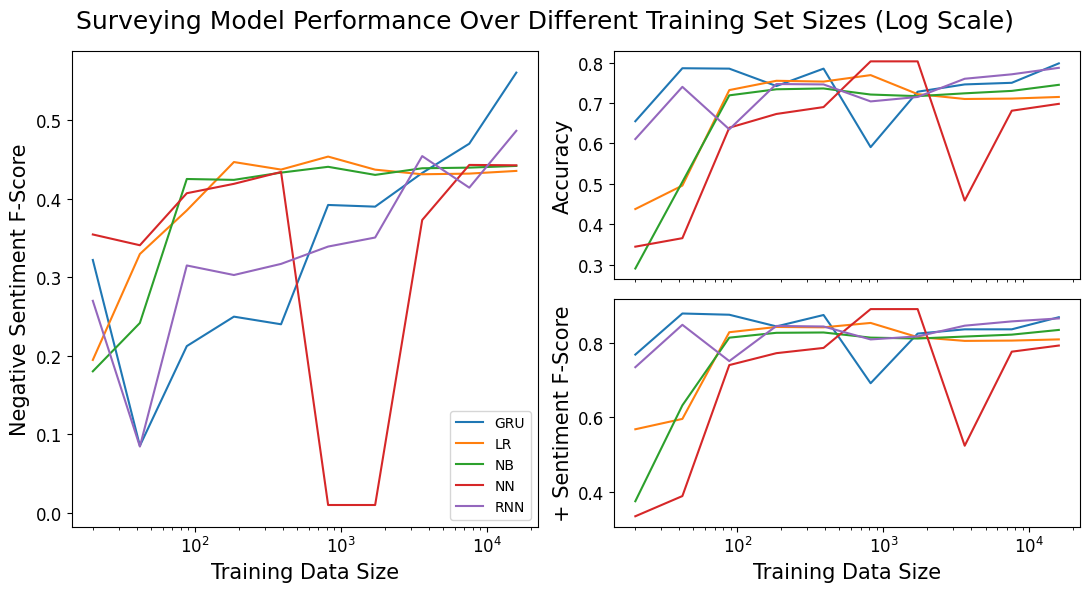

In [162]:
plt.figure(figsize = (11,6))

ax1 = plt.subplot(1,2,1)
for model, _ in results.groupby(level = 0):
    results.loc[model]["(-) F"].plot(label = model, ax = ax1)
ax1.set_xscale("log")
ax1.set_xlabel("Training Data Size", fontsize = 15)
ax1.set_ylabel("Negative Sentiment F-Score", fontsize = 15)
ax1.tick_params(labelsize = 12)
ax1.legend(loc = "lower right")

ax2 = plt.subplot(2,2,2)
for model, _ in results.groupby(level = 0):
    results.loc[model]["Accuracy"].plot(label = model, ax = ax2)
ax2.set_xscale("log")
ax2.tick_params(labelsize = 12)
ax2.set_xticks([])
ax2.set_xlabel("")
ax2.set_ylabel("Accuracy", fontsize = 15)

ax3 = plt.subplot(2,2,4)
for model, _ in results.groupby(level = 0):
    results.loc[model]["(+) F"].plot(label = model, ax = ax3)
ax3.set_xlabel("Training Data Size", fontsize = 15)
ax3.set_xscale("log")
ax3.tick_params(labelsize = 12)
ax3.set_ylabel("+ Sentiment F-Score", fontsize = 15)

plt.suptitle("Surveying Model Performance Over Different Training Set Sizes (Log Scale)", fontsize = 18)
plt.tight_layout()

In [474]:
GRU(X_ts, X_TEST_TS, y_ts, Y_TEST_TS, vocab_analysis = True)

32/32 [==============================] - 0s 3ms/step

Ten Most Positive Words:
['meh', 'twist', 'disappointed', 'eh', 'worst', 'button', 'three', 'tedious', 'awful', 'clone']

Ten Most Negative Words:
['exactly', 'childhood', 'dragon', 'thief', 'truly', 'learning', 'tennis', 'roleplaying', 'timeless', 'ffs']


# Appendix

In [54]:
# CODE FOR LOOKING AT LOSS

# plt.figure(figsize = (11,6))
# plt.loglog(history.history["loss"], label = "Training Loss")
# plt.loglog(history.history["val_loss"], label = "Validation Loss")
# plt.legend(loc = "upper right")
# plt.xlabel("# Epochs")
# plt.ylabel("Binary Cross-Entropy Loss")
# plt.title("Evolution of Loss in Training (Log-Log)")
# plt.show()